# Modeling Agricultural Variables
## Python modules

In [3]:
import warnings
import time
import os
import random

import dask
from dask.distributed import Client

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import multiprocessing as mp

import geopandas as gpd
import pyarrow

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import mean_squared_error, confusion_matrix, r2_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr
from sklearn.utils import check_random_state, resample
from joblib import Parallel, delayed

import math
import seaborn as sns

## Read in Data

We first read in the aggregated features and ground-truth data joined in  feature_preprocessing.ipynb 

In [28]:
grouped_features = pd.read_csv("/capstone/mosaiks/repos/modeling/data/model_directory/SEA_averaged_features_simple_impute_modeltrain.csv")
grouped_features

,year,sea_unq,index_left,lon,lat,0_1,0_2,0_3,0_4,0_5,...,prop_mix,log_maize,log_sweetpotatoes,log_groundnuts,log_soybeans,loss_ind,drought_loss_ind,flood_loss_ind,animal_loss_ind,pest_loss_ind
0,2016.0,1,46302.000000,27.807993,-13.659357,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.058626,5.269229,7.640386,6.977090,0.0,0.0,0.0,0.0,0.0
1,2016.0,7,51611.666667,28.634660,-13.772690,0.001141,0.000329,0.000329,0.000329,0.000000,...,0.181102,3.387211,0.689155,7.707512,7.113191,1.0,1.0,0.0,0.0,0.0
2,2016.0,9,44806.714286,27.406446,-12.905428,0.000006,0.000006,0.000006,0.000006,0.000004,...,0.069018,2.703935,8.486127,-1.408767,7.141370,1.0,0.0,0.0,0.0,0.0
3,2016.0,10,44644.411765,27.381719,-12.962298,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.714757,2.525729,3.354421,6.929734,1.0,0.0,0.0,0.0,0.0
4,2016.0,12,47769.000000,28.014660,-12.889357,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.786884,8.509161,2.852125,0.798508,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,2021.0,347,22038.000000,25.204660,-14.879357,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,7.952872,8.294050,8.079163,7.021973,1.0,1.0,0.0,0.0,0.0
535,2021.0,348,19562.000000,24.774660,-14.799357,0.000000,0.000000,0.000018,0.000039,0.000071,...,0.000000,7.642350,8.070906,8.429997,8.006368,1.0,1.0,0.0,0.0,0.0
536,2021.0,355,15659.538462,24.260045,-14.563972,0.000038,0.000038,0.001014,0.000033,0.000028,...,0.000000,7.508878,7.665441,8.211719,5.238174,1.0,0.0,0.0,0.0,0.0
537,2021.0,356,19411.000000,24.752993,-14.764357,0.000158,0.000158,0.000246,0.000040,0.000038,...,0.000000,7.608263,9.042113,8.224773,8.028346,1.0,0.0,0.0,0.0,0.0


ERROR 1: PROJ: proj_create_from_database: Open of /Users/andrewbartnik/.conda/envs/mosaiks/share/proj failed


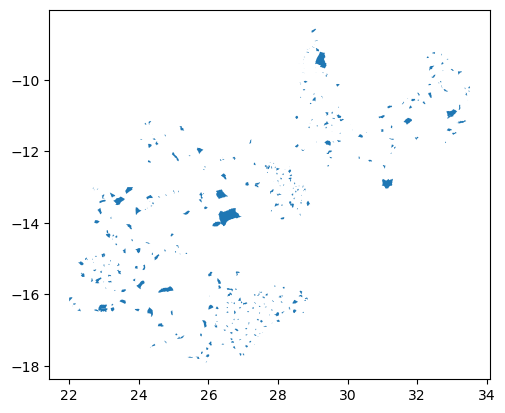

In [5]:
# Read in the survey data
country_sea = gpd.read_file('/capstone/mosaiks/repos/preprocessing/data/ground_data_spatial/updated_data.shp')
# Filter country_sea for unique values of 'seq_unq' and 'geometry'
sea_unq_join = country_sea[['sea_unq', 'geometry']].drop_duplicates()

# Plotting
fig, ax = plt.subplots(1, 1)
sea_unq_join.plot(ax=ax)
plt.show()


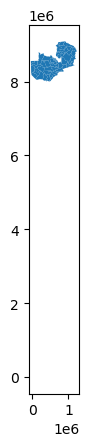

In [6]:
# Read in the survey data
sea = gpd.read_file('/capstone/mosaiks/repos/preprocessing/sitian/data/SEA_Shape_all.shp')
boundaries = gpd.read_file('/capstone/mosaiks/box/Shapefiles/spatial/zam_districts/ZAM_Districts.shp')

# Plotting
fig, ax = plt.subplots(1, 1)
boundaries.plot(ax=ax)
sea.plot(ax=ax)
plt.show()

In [7]:
boundaries
sea

,FID,geometry
0,0,"POLYGON ((28.71362 -14.50631, 28.71365 -14.506..."
1,1,"POLYGON ((28.66956 -14.63660, 28.66957 -14.636..."
2,2,"POLYGON ((28.51828 -14.57855, 28.51901 -14.579..."
3,3,"POLYGON ((28.67764 -14.88801, 28.68266 -14.887..."
4,4,"POLYGON ((28.34812 -14.82430, 28.34812 -14.824..."
...,...,...
644,644,"POLYGON ((24.74318 -17.29921, 24.74343 -17.299..."
645,645,"POLYGON ((24.46976 -17.42445, 24.47061 -17.425..."
646,646,"POLYGON ((24.34614 -17.47451, 24.34577 -17.474..."
647,647,"POLYGON ((24.36564 -16.62152, 24.35000 -16.617..."


In [8]:
features = grouped_features.iloc[:,5:12005]
features.head()

,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,0_10,...,999_3,999_4,999_5,999_6,999_7,999_8,999_9,999_10,999_11,999_12
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,6.157999e-06,0.000207,0.000000,...,1.000000,1.000000,0.274676,1.000000,0.115388,0.002708,0.001319,1.000000,1.000000,1.000000
1,0.001141,0.000329,0.000329,0.000329,0.000000,0.00000,0.000000,1.008277e-03,0.001360,0.002211,...,0.006789,0.006789,1.000000,1.000000,1.000000,0.000517,0.000343,0.000396,0.000327,0.004724
2,0.000006,0.000006,0.000006,0.000006,0.000004,0.00001,0.000014,2.590917e-05,0.000110,0.000109,...,0.005561,0.005561,0.006391,0.004212,0.003235,0.001937,0.001683,0.001970,0.002340,0.005251
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3.113844e-07,0.000012,0.000000,...,0.005570,0.005570,0.006739,0.003991,0.002857,0.001979,0.001435,0.001284,0.001814,0.007540
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,9.700000e-06,0.000186,0.000166,...,1.000000,1.000000,1.000000,1.000000,0.002690,0.001603,0.000820,0.001269,0.001692,0.018616


In [9]:
outcomes = grouped_features.iloc[:,12006:]

outcomes["loss_ind"].astype('category')
outcomes["drought_loss_ind"].astype('category')
outcomes['pest_loss_ind'].astype('category')
outcomes['animal_loss_ind'].astype('category')
outcomes['flood_loss_ind'].astype('category')
outcomes.head()

,total_area_harv_ha,total_area_lost_ha,total_harv_kg,yield_kgha,frac_area_harv,frac_area_loss,area_lost_fire,maize,groundnuts,mixed_beans,...,prop_mix,log_maize,log_sweetpotatoes,log_groundnuts,log_soybeans,loss_ind,drought_loss_ind,flood_loss_ind,animal_loss_ind,pest_loss_ind
0,71.0,5.0,4400.0,57.894737,0.934211,0.065789,0.0,57.894737,0.000000,0.000000,...,0.000000,4.058626,5.269229,7.640386,6.977090,0.0,0.0,0.0,0.0,0.0
1,607.0,409.0,8730.0,8.592520,0.597441,0.402559,0.0,29.583333,0.000000,0.434783,...,0.181102,3.387211,0.689155,7.707512,7.113191,1.0,1.0,0.0,0.0,0.0
2,462.0,190.0,7930.0,12.162577,0.708589,0.291411,0.0,14.938398,0.244444,5.366667,...,0.069018,2.703935,8.486127,-1.408767,7.141370,1.0,0.0,0.0,0.0,0.0
3,410.0,135.0,19975.0,36.651376,0.752294,0.247706,0.0,41.048593,28.629032,0.000000,...,0.000000,3.714757,2.525729,3.354421,6.929734,1.0,0.0,0.0,0.0,0.0
4,252.0,98.0,5175.0,14.785714,0.720000,0.280000,0.0,16.230366,17.324561,0.000000,...,0.000000,2.786884,8.509161,2.852125,0.798508,1.0,0.0,0.0,0.0,0.0


## Model

We define a model to predict each of our outcome variables on our features for each SEA/year. The `train_and_evaluate_models` function trains and evaluates Ridge Linear Regression models for each target variable specified in the `target_columns` parameter. It handles both categorical and continuous target variables and provides the option to block sample on specific SEAs (Survey Enumeration Areas) by providing the SEA IDs to hold out for the validation set.

The function works as follows:

1. Read the grouped features and outcomes from a CSV file.
2. Define a helper function `block_sampling` to perform block sampling based on the provided SEA IDs.
3. For each target variable in `target_columns`, select the corresponding target variable data.
4. If `block_sea_ids` is provided and not empty, perform block sampling using the `block_sampling` helper function. Otherwise, use `train_test_split` to split the data into training and testing sets.
5. Train a Ridge Linear Regression model using RidgeCV with 5-fold cross-validation and a range of alpha values.
6. If the target variable is categorical, calculate and print the false positive rate and AUC-ROC. If the target variable is continuous, calculate and print the estimated regularization parameter, training R2 performance, validation R2 performance, and Pearson's correlation coefficient.

### Helper Function for Confusion Matrix for Categorical Variables
`calculate_confusion_matrix`:
This function calculates the confusion matrix for binary classification problems based on the given true labels (`y_true`), predicted values (`y_pred`), and a decision boundary (`decision_boundary`). The decision boundary is used to threshold the predicted values to obtain binary predictions.

Inputs:

`y_true`: The true labels of the target variable (a pandas Series or numpy array).

`y_pred`: The predicted values of the target variable (a numpy array).

`decision_boundary`: A float value that serves as the threshold for classifying the predicted values into two classes (0 or 1).


The function performs the following steps:
1. It adjusts the predicted values by setting them to 1 if they are greater than or equal to the decision boundary, and 0 otherwise.
2. It calculates the confusion matrix using the true labels and adjusted predicted values.
3. Depending on the shape of the confusion matrix, it extracts the true negatives (tn), false positives (fp), false negatives (fn), and true positives (tp).
4. If the shape of the confusion matrix is not (1, 1) or (2, 2), it raises an error.

Output: The function returns the values of tn, fp, fn, and tp.

In [10]:
def calculate_confusion_matrix(y_true, y_pred, decision_boundary):
    y_pred_adj = np.where(y_pred >= decision_boundary, 1, 0)
    cm = confusion_matrix(y_true, y_pred_adj)
    if cm.shape == (1, 1):
        if y_true.iloc[0] == 0:
            tn, fp, fn, tp = cm[0, 0], 0, 0, 0
        else:
            tn, fp, fn, tp = 0, 0, 0, cm[0, 0]
    elif cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        print("Unexpected confusion matrix:")
        print(cm)
        raise ValueError('Unexpected confusion matrix shape.')
    return tn, fp, fn, tp

### Helper Function for Block Sampling on SEAs

This function randomly selects a specified number of unique SEA IDs from the `grouped_features` DataFrame.

Inputs:

1. n: The number of unique SEA IDs to select.

2. `grouped_features`: A DataFrame containing the feature data with a column '`sea_unq`' that stores the unique SEA IDs.

The function performs the following steps:

1. It extracts the unique SEA IDs from the '`sea_unq`' column of the `grouped_features` DataFrame.

2. It randomly selects n SEA IDs from the unique SEA IDs without replacement.

Output: The function returns a numpy array of the randomly selected SEA IDs.

These helper functions are used in the main model as follows:

`calculate_confusion_matrix` is used to calculate the confusion matrix for the categorical target variables. It is called in the `train_and_evaluate_models` function to compute the false positive rate and AUC-ROC for different decision boundaries.

`randomly_select_seas` is not used in the current implementation of the main model. However, it can be used to randomly select SEA IDs if you want to implement a custom sampling strategy.

In [11]:
def randomly_select_seas(n, grouped_features):
    unique_seas = grouped_features['sea_unq'].unique()
    selected_seas = np.random.choice(unique_seas, n, replace=False)
    return selected_seas

## Cross-Validator Custom Class

This custom cross-validator class, BlockSamplingCV, inherits from the BaseCrossValidator class in scikit-learn. It is designed to perform block sampling for cross-validation, holding out specific groups of observations (in this case, SEA IDs) during each split. This ensures that all observations with the same SEA ID are either in the training set or the test set, but not both.

Here's a detailed explanation of the class:

__init__(self, n_splits=5, n_seas_to_hold_out=10, sea_ids=None, random_state=None):
The constructor takes the following arguments:

n_splits: The number of cross-validation splits (default is 5).
n_seas_to_hold_out: The number of SEAs to hold out in each cross-validation split (default is 10).
sea_ids: A list or array of SEA IDs corresponding to the rows of the dataset (default is None).
random_state: An integer seed or a RandomState instance for reproducible results (default is None).
The constructor initializes the class with these arguments.

_iter_test_indices(self, X=None, y=None, groups=None):
This method generates test indices for each cross-validation split. It takes the following optional arguments:

X: Feature matrix (not used in this method but included for compatibility with scikit-learn).
y: Target variable (not used in this method but included for compatibility with scikit-learn).
groups: Group labels for the samples used to ensure that each group is either entirely in the training or test set (not used in this method but included for compatibility with scikit-learn).
The method performs the following steps:

a. It calculates the total number of samples and extracts the unique SEA IDs from the sea_ids attribute.
b. It initializes a random number generator with the specified random_state.
c. For each split, it randomly selects a set of n_seas_to_hold_out SEA IDs without replacement.
d. It finds the indices of the observations with the selected SEA IDs and yields them as test indices for the current split.

The BlockSamplingCV class is designed to perform cross-validation with block sampling, where groups of observations (in this case, SEA IDs) are held out together during each split. This is useful because it ensures that all observations with the same SEA ID are either in the training set or the test set, but not both. This can help prevent leakage of information between the training and test sets when observations with the same SEA ID are strongly correlated.

In [12]:
def get_train_val_test_indices(sea_ids, n_seas_to_hold_out_for_val, n_seas_to_hold_out_for_test, random_state):
    unique_seas = np.unique(sea_ids)
    np.random.seed(random_state)
    np.random.shuffle(unique_seas)

    # Hold out some SEAs for testing
    test_seas = unique_seas[:n_seas_to_hold_out_for_test]
    remaining_seas = unique_seas[n_seas_to_hold_out_for_test:]

    # Hold out some SEAs for validation
    val_seas = remaining_seas[:n_seas_to_hold_out_for_val]
    train_seas = remaining_seas[n_seas_to_hold_out_for_val:]

    # Convert boolean indices to integer indices
    train_indices = np.where(sea_ids.isin(train_seas))[0]
    val_indices = np.where(sea_ids.isin(val_seas))[0]
    test_indices = np.where(sea_ids.isin(test_seas))[0]

    return train_indices, val_indices, test_indices, train_seas, val_seas, test_seas


In [13]:
# Prepare the arguments as a dictionary
args = {
    'target_columns': ['frac_area_harv', 'log_maize'],
    'test_size': 0.1,
    'categorical_columns':[],
    'decision_boundaries': [0.5],
    'sea_ids': grouped_features['sea_unq'],
    'validation_size' : 0.1,
    'bootstrap' : True,
    'n_bootstraps': 10,
    'block_sample': False,
    'n_seas_held_out_val': None,
    'n_seas_held_out_test': None,
    'random_state': 50
}

In [14]:
def train_and_evaluate_models(args):
    target_columns = args['target_columns']
    test_size = args.get('test_size', 0.1)
    categorical_columns = args['categorical_columns']
    decision_boundaries = args['decision_boundaries']
    sea_ids = args['sea_ids']
    validation_size = args.get('validation_size', 0.1)
    bootstrap = args.get('bootstrap', False)
    n_bootstraps = args.get('n_bootstraps', 0)
    block_sample = args.get('block_sample', False)
    random_state = args.get('random_state', False)
    n_seas_held_out_val = args.get('n_seas_held_out_val', 30)
    n_seas_held_out_test = args.get('n_seas_held_out_test', 10)
    
    
    grouped_features = pd.read_csv("/capstone/mosaiks/repos/modeling/data/model_directory/SEA_averaged_features_simple_impute_modeltrain.csv")

    features = grouped_features.iloc[:, 5:12005]
    outcomes = grouped_features.iloc[:, 12006:]

    # Initialize an empty DataFrame to store the predictions
    predictions_df = pd.DataFrame()
    
    # Initialize an empty DataFrame to store groundtruth
    groundtruth_df = pd.DataFrame()
    all_ridge_models=dict()
    # Initialize an empty DataFrame to store the train data
    train_df = pd.DataFrame()

    # Initialize an empty DataFrame to store the validation data
    val_df = pd.DataFrame()

    
    
    print(f"\nRunning model with the following parameters:")
    print(f"Target columns: {target_columns}")
    print(f"Test size: {test_size}", f"Validation size: {validation_size}")
    print(f"Bootstrap: {bootstrap}")
    print(f"Random State: {random_state}")
    if bootstrap:
        print(f"Number of bootstrapped samples: {n_bootstraps}")
    print(f"Block sample: {block_sample}\n")
    # If block_sample is True, then use block sampling
    if block_sample:
        # Get train, validation and test indices
        train_indices, val_indices, test_indices, train_seas, val_seas, test_seas = get_train_val_test_indices(sea_ids, n_seas_to_hold_out_for_val=n_seas_held_out_val, n_seas_to_hold_out_for_test=n_seas_held_out_test, random_state=random_state)
        print(f"Number of seas held out for validation: {n_seas_held_out_val}\n")
        print(f"Training SEAs: {train_seas}")
        print(f"Validation SEAs: {val_seas}")
        print(f"Testing SEAs: {test_seas}")
        

    for target_column in target_columns:

        # If block_sample is True, then use block sampling
        if bootstrap and block_sample:
            X_train, X_test = features.iloc[train_indices], features.iloc[test_indices]
            y_train, y_test = outcomes[target_column].iloc[train_indices], outcomes[target_column].iloc[test_indices]
            
        elif bootstrap:
            # Split the data into training and test sets
            X_train, X_test, y_train, y_test = train_test_split(features, outcomes[target_column], test_size=test_size, random_state=random_state)
            
        elif block_sample:
            # Use the already obtained train_indices, val_indices, and test_indices
            # Create train, validation and test sets using the indices
            X_train, X_val, X_test = features.iloc[train_indices], features.iloc[val_indices], features.iloc[test_indices]
            y_train, y_val, y_test = outcomes[target_column].iloc[train_indices], outcomes[target_column].iloc[val_indices], outcomes[target_column].iloc[test_indices]
            
        else:
            X_train, X_test, y_train, y_test = train_test_split(features, outcomes[target_column], test_size=test_size, random_state = random_state)
            # Split the training data again to create a validation set
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state = random_state)

        sea_ids_train = sea_ids[X_train.index]  # Update the sea_ids for the training set
        sea_ids_test = sea_ids[X_test.index]  
        
        if bootstrap:
            
            ridge_models_scores = []  # Initialize an empty list to store the ridge models for this target column
            val_scores =[]
    
            # Set the random seed for reproducibility
            rng = np.random.default_rng(random_state)
            # Define function for each bootstrap iteration
            def bootstrap_iteration(i):
                # Create a unique seed for this bootstrap iteration
                seed = random_state + i
                # Initialize the random number generator with the unique seed
                rng = np.random.default_rng(seed)
                # Create a bootstrapped training dataset
                indices = rng.choice(len(X_train), size=len(X_train), replace=True)
                X_train_bootstrap = X_train.iloc[indices]
                y_train_bootstrap = y_train.iloc[indices]
                X_train_bootstrap, X_val_bootstrap, y_train_bootstrap, y_val_bootstrap = train_test_split(X_train_bootstrap, y_train_bootstrap, test_size=validation_size, random_state=random_state)

                # Print the first few rows of the bootstrap sample
               # print(f"Bootstrap sample {i}:")
               # print(pd.concat([X_train_bootstrap, y_train_bootstrap], axis=1).head())

                # Fit the model to the bootstrapped data
                cv = 5
                ridge_cv = RidgeCV(cv=cv, alphas=np.logspace(-8, 8, base=10, num=75))
                ridge_cv.fit(X_train_bootstrap, y_train_bootstrap)

                # Make predictions
                train_pred = ridge_cv.predict(X_train_bootstrap)
                val_pred = ridge_cv.predict(X_val_bootstrap)

                # Calculate scores
                train_score = ridge_cv.score(X_train_bootstrap, y_train_bootstrap)
                val_score = r2_score(y_val_bootstrap, ridge_cv.predict(X_val_bootstrap))  # Compute val_score here
                
                
                # Calculate Pearson's correlation coefficient
                pearson_coeff, _ = pearsonr(y_val_bootstrap, val_pred)

                # Append model and score to lists
                ridge_models_scores.append((ridge_cv, val_score))
                val_scores.append(val_score)  # Append val_score after it's computed

                all_ridge_models[target_column] = ridge_models_scores
                
                                # Calculate false positive rate and AUC-ROC if the target variable is categorical
                if target_column in categorical_columns:
                    y_val_pred = ridge_cv.predict(X_val_bootstrap)
                    fpr = 0
                    auc_roc = 0
                    for decision_boundary in decision_boundaries:
                        # Calculate confusion matrix
                        tn, fp, fn, tp = calculate_confusion_matrix(y_val_bootstrap, y_val_pred, decision_boundary)
                        # Calculate the false positive rate
                        fpr += fp / (fp + tn)
                        # Calculate AUC-ROC
                        auc_roc += roc_auc_score(y_val_bootstrap, y_val_pred)
                    fpr /= len(decision_boundaries)  # Get average false positive rate
                    auc_roc /= len(decision_boundaries)  # Get average AUC-ROC
                    return ridge_cv.coef_, train_score, val_score, pearson_coeff, fpr, auc_roc, (y_train_bootstrap, train_pred), (y_val_bootstrap, val_pred),ridge_models_scores
                else:
                    return ridge_cv.coef_, train_score, val_score, pearson_coeff, None, None, (y_train_bootstrap, train_pred), (y_val_bootstrap, val_pred),ridge_models_scores

            # Run bootstrap iterations in parallel
            results = Parallel(n_jobs=-1)(delayed(bootstrap_iteration)(i) for i in range(n_bootstraps))

            # Unpack results
            coefs, train_scores, val_scores, pearson_coeffs, false_positive_rates, auc_rocs, train_data, val_data,ridge_models_list = zip(*results)

            all_ridge_models[target_column] = ridge_models_list

            # Calculate the average coefficients and validation scores
            avg_coefs = np.mean(coefs, axis=0)
            avg_train_score = np.mean(train_scores)
            avg_val_score = np.mean(val_scores)
            avg_pearson_coeff = np.mean(pearson_coeffs)
            
                # Convert training and validation data to DataFrames
            train_df_temp = pd.DataFrame([(y_train, pred) for y_train, pred in train_data], columns=[f'{target_column}_y_train', f'{target_column}_train_pred'])
            val_df_temp = pd.DataFrame([(y_val, pred) for y_val, pred in val_data], columns=[f'{target_column}_y_val', f'{target_column}_val_pred'])

            # Calculate the average prediction and value across each bootstrap sample for each target variable
            train_df[f'{target_column}_y_train'] = train_df_temp[f'{target_column}_y_train'].apply(np.mean)
            train_df[f'{target_column}_train_pred'] = train_df_temp[f'{target_column}_train_pred'].apply(np.mean)
            val_df[f'{target_column}_y_val'] = val_df_temp[f'{target_column}_y_val'].apply(np.mean)
            val_df[f'{target_column}_val_pred'] = val_df_temp[f'{target_column}_val_pred'].apply(np.mean)
            
                    # Concatenate the results to the existing dataframes
            train_df = pd.concat([train_df, train_df_temp], axis=1)
            val_df = pd.concat([val_df, val_df_temp], axis=1)


            return None, None, None, train_df, val_df, all_ridge_models
            
            
                        # Calculate the average false positive rate and AUC-ROC for categorical variables
            if target_column in categorical_columns:
                avg_false_positive_rate = np.nanmean(false_positive_rates)
                avg_auc_roc = np.nanmean(auc_rocs)
                print(f"Average false positive rate: {avg_false_positive_rate:0.2f}")
                print(f"Average AUC-ROC: {avg_auc_roc:0.2f}")

            print(f"Target variable: {target_column}")
            print(f"Average training R2 score: {avg_train_score:0.2f}")
            print(f"Average validation R2 score: {avg_val_score:0.2f}")
            print(f"Average Pearson's correlation coefficient: {avg_pearson_coeff:0.2f}")
            print()
            

        else:
            cv = 5
            ridge_cv = RidgeCV(cv=cv, alphas=np.logspace(-8, 8, base=10, num=75))
            ridge_cv.fit(X_train, y_train)
            

            # Make predictions on the test data
            y_val_pred = ridge_cv.predict(X_val)
    
            # Update the predictions DataFrame with the new predictions
            predictions_df[target_column] = y_val_pred
    
            if target_column in categorical_columns:
                for decision_boundary in decision_boundaries:
                    # Calculate confusion matrix
                    tn, fp, fn, tp = calculate_confusion_matrix(y_val, y_val_pred, decision_boundary)

                # Calculate the false positive rate
                    false_positive_rate = fp / (fp + tn)

                # Calculate AUC-ROC
                    auc_roc = roc_auc_score(y_val, y_val_pred)

                    print(f"Target variable: {target_column} (Categorical)")
                    print(f"Decision boundary: {decision_boundary}")
                    print(f"False positive rate: {false_positive_rate:0.2f}")
                    print(f"AUC-ROC: {auc_roc:0.2f}")
                    print()
                    
            else:
                # Calculate Pearson's correlation coefficient
                pearson_coeff, _ = pearsonr(y_val, y_val_pred)

                # Calculate training R squared
                train_r_squared = ridge_cv.score(X_train, y_train)

                # Calculate validation R squared
                val_r_squared = ridge_cv.score(X_val, y_val)
                
                metrics_df = metrics_df.append({
                'target_column': target_column,
                'train_score': train_r_squared,
                'val_score': val_r_squared,
                'pearson_coeff': pearson_coeff}, ignore_index=True)
                    
                print()
                print(f"Target variable: {target_column}")
                print(f"Estimated regularization parameter: {ridge_cv.alpha_}")
                print(f"Training R2 performance: {train_r_squared:0.2f}")
                print(f"Validation R2 performance: {val_r_squared:0.2f}")
                print(f"Pearson's correlation coefficient: {pearson_coeff:0.2f}")
                print()

    return predictions_df, metrics_df, results_df, train_df, val_df, all_ridge_models


In [15]:
predictions_df, metrics_df, results_df, train_df, val_df, all_ridge_models = train_and_evaluate_models(args)


Running model with the following parameters:
Target columns: ['frac_area_harv', 'log_maize']
Test size: 0.1 Validation size: 0.1
Bootstrap: True
Random State: 50
Number of bootstrapped samples: 10
Block sample: False



In [16]:
all_ridge_models


{'frac_area_harv': ([(RidgeCV(alphas=array([1.00000000e-08, 1.64519059e-08, 2.70665207e-08, 4.45295851e-08,
           7.32596543e-08, 1.20526094e-07, 1.98288395e-07, 3.26222201e-07,
           5.36697695e-07, 8.82969996e-07, 1.45265393e-06, 2.38989257e-06,
           3.93182876e-06, 6.46860766e-06, 1.06420924e-05, 1.75082703e-05,
           2.88044415e-05, 4.73887961e-05, 7.79636013e-05, 1.28264983e-04,
           2.11020343e-04, 3.47168682e-0...
           1.75082703e+03, 2.88044415e+03, 4.73887961e+03, 7.79636013e+03,
           1.28264983e+04, 2.11020343e+04, 3.47168682e+04, 5.71158648e+04,
           9.39664831e+04, 1.54592774e+05, 2.54334576e+05, 4.18428851e+05,
           6.88395207e+05, 1.13254132e+06, 1.86324631e+06, 3.06539530e+06,
           5.04315949e+06, 8.29695852e+06, 1.36500781e+07, 2.24569800e+07,
           3.69460121e+07, 6.07832313e+07, 1.00000000e+08]),
            cv=5),
    0.635437085494561)],
  [(RidgeCV(alphas=array([1.00000000e-08, 1.64519059e-08, 2.70665207

In [17]:
class SingleVariableEnsembleModel:
    def __init__(self, models_with_scores):
        self.models_with_scores = models_with_scores

    def predict(self, X):
        total_weight = sum(score for _, score in self.models_with_scores)
        prediction = 0
        for model, weight in self.models_with_scores:
            prediction += (model.predict(X) * weight) / total_weight
        return prediction

In [18]:
models_with_scores = all_ridge_models['frac_area_harv']

ensemble_model = SingleVariableEnsembleModel(models_with_scores)

In [23]:
models_and_scores = {}

for key in all_ridge_models.keys():
    models_with_scores = all_ridge_models[key][0] # this gives you the list of tuples
    models_and_scores[key] = SingleVariableEnsembleModel(models_with_scores)


In [27]:
models_and_scores

{'frac_area_harv': <__main__.SingleVariableEnsembleModel at 0x7fee4e4fda50>}

In [20]:
all_ridge_models['frac_area_harv'][0]

[(RidgeCV(alphas=array([1.00000000e-08, 1.64519059e-08, 2.70665207e-08, 4.45295851e-08,
         7.32596543e-08, 1.20526094e-07, 1.98288395e-07, 3.26222201e-07,
         5.36697695e-07, 8.82969996e-07, 1.45265393e-06, 2.38989257e-06,
         3.93182876e-06, 6.46860766e-06, 1.06420924e-05, 1.75082703e-05,
         2.88044415e-05, 4.73887961e-05, 7.79636013e-05, 1.28264983e-04,
         2.11020343e-04, 3.47168682e-0...
         1.75082703e+03, 2.88044415e+03, 4.73887961e+03, 7.79636013e+03,
         1.28264983e+04, 2.11020343e+04, 3.47168682e+04, 5.71158648e+04,
         9.39664831e+04, 1.54592774e+05, 2.54334576e+05, 4.18428851e+05,
         6.88395207e+05, 1.13254132e+06, 1.86324631e+06, 3.06539530e+06,
         5.04315949e+06, 8.29695852e+06, 1.36500781e+07, 2.24569800e+07,
         3.69460121e+07, 6.07832313e+07, 1.00000000e+08]),
          cv=5),
  0.635437085494561)]

In [66]:
predictions = ensemble_model.predict(grouped_features)


IndexError: list index out of range

In [ ]:
kwargs_list = [
    { 
        'target_columns': ['frac_area_harv', 'drought_loss_ind', 'maize', 'log_maize', 'frac_loss_drought'],
        'test_size': 0.1,
        'categorical_columns':['drought_loss_ind'],
        'decision_boundaries': [0.5],
        'sea_ids': grouped_features['sea_unq'],  # You'll need to define grouped_features somewhere before this
        'validation_size' : 0.1,
        'bootstrap' : False,
        'n_bootstraps': None,
        'block_sample': False,
        'n_seas_held_out_val': None,
        'n_seas_held_out_test': None,
        'random_state': random_state  # This now uses the random_state from the loop
    }
    for i, random_state in enumerate(random_seeds)
]

with ProcessPoolExecutor() as executor:
    futures = [
        executor.submit(train_and_evaluate_models, **kwargs) for kwargs in kwargs_list
    ]

    predictions_dfs = []
    metrics_dfs = []
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing splits"):
        # Get the result
        result = future.result()

        # Separate the predictions and metrics from the result
        predictions_df, metrics_df = result

        # Append the results to the corresponding lists
        predictions_dfs.append(predictions_df)
        metrics_dfs.append(metrics_df)


#### 

In [47]:
zambia = pd.read_feather("/capstone/mosaiks/repos/modeling/data/features_zmb_save.feather")

In [48]:
zambia.head()

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,lon,lat,year,month
0,0.000185,0.0,0.000639,0.520889,0.017403,0.0,0.003055,1.075246,0.0,0.0,...,0.004387,2.898772,3.899328,0.019313,0.956588,0.000149,27.800588,-16.343257,2015,7
1,0.000165,0.0,0.000140,0.506241,0.010501,0.0,0.001828,1.070585,0.0,0.0,...,0.003691,2.874976,3.857865,0.023663,0.927871,0.000587,27.790588,-16.343257,2015,7
2,0.000679,0.0,0.001090,0.584611,0.021318,0.0,0.006663,1.202663,0.0,0.0,...,0.007180,2.960961,3.987956,0.021282,0.891021,0.000574,27.780588,-16.353257,2015,7
3,0.000502,0.0,0.003195,0.692933,0.034732,0.0,0.009775,1.366068,0.0,0.0,...,0.008007,3.097285,4.168679,0.009190,0.847190,0.000006,27.720588,-16.363257,2015,7
4,0.000162,0.0,0.003317,0.766315,0.039693,0.0,0.013185,1.480798,0.0,0.0,...,0.008061,3.172538,4.296293,0.017217,0.834277,0.000000,27.730588,-16.363257,2015,7


### Train set

In [ ]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)
r2_train = r2_score(y_train, y_pred)

fig, ax = plt.subplots(ncols=1)
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {r2_train:0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.axline([0, 0], [1, 1], c = "k")

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)


# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()
# the model is plotted with a black 45 degree line that serves as a reference of what a perfect correlation would look like
# deviation of the line indicates that there is not a perfect correlation

In [ ]:
print(f"Training R^2 = {r2_train:0.2f}\nPearsons r = {pearsonr(y_pred, y_train)[0]:0.2f}") 

In [ ]:
# Pearson r^2
pearsonr(y_pred, y_train)[0] ** 2

In [ ]:
# alternative way to calculate Training R^2
ridge_cv_random.score(x_train, y_train)

### Test set

In [ ]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)
r2_test = r2_score(y_test, y_pred)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {r2_test:0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.axline([0, 0], [.75, .75], c = "k")

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [ ]:
print(f"Testing set R^2 = {r2_test:0.2f}")
print(f"Testing set pearsons R = {pearsonr(y_pred, y_test)[0]:0.2f}")

Summary of both train and test data sets

In [ ]:
y_pred = np.maximum(ridge_cv_random.predict(x_all), 0)

fig, ax = plt.subplots(figsize=(7, 7))
ax.axline([0, 0], [.75, .75], c = "k")
plt.scatter(y_pred, y_all, alpha=.9, s=15)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Observed", fontsize=15)
plt.text(
    0, .8, fontsize=15, fontweight="bold",
    s=f"R$^2$={r2_train:0.2f} - Train set",
)
plt.text(
    0, .75, fontsize=15, fontweight="bold",
    s=f"R$^2$={ridge_cv_random.best_score_:0.2f} - Validation set",
)
plt.text(
    0, .7, fontsize=15, fontweight="bold",
    s=f"R$^2$={r2_test:0.2f} - Test set",
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_all_data.jpg', dpi=300)
plt.show()
plt.close()

### Use the trained model to predict crop yields over all years from 1km grid-cell resolution features 

Recall that after we executed imputation on all feature years in the dataframe `features`, we copied the dataframe and named it `features_all_years`. Now we can plug that into the model to visualize how our model performs over time.

In [ ]:
# recall the object we created earlier, before we split the features by year into those that would train the model 
# and those that would be fed into the trained model to predict crop yields
# in years for which we do not have crop data
features_all_years.head(3)

In the following chunk, we drop certain columns from `features_all_years` because we only need to feed the feature data into the model to generate predictions. Using the argument `axis = 1`, we specify that we are dropping columns rather than rows. 

In [ ]:
x_all = features_all_years.drop([
    'year', 
    'geometry',
    'district',
    'crop_perc'
], axis = 1)

In the following chunk, we execute the model on the features from the dataframe `features_all_years`. The crop yield predictions for each row populate a new column in the dataframe.

The model is run inside the `np.maximum()` function because if we run it without being wrapped inside function, some crop predictions are negative values, but we need them all to be positive because conceptually crop yields cannot be negative.

In [ ]:
features_all_years['yield_prediction'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [ ]:
# check out the dataframe with the new column of predictions
features_all_years.head(3)

The dataframe is already a geodataframe, so we do not have to convert it to one before mapping predictions. However, we do need to replace all the zero value crop percentage areas with `NA`. We do this by applying the `mask()` function. This function is similar to an if-else statement. If the value of the `crop_perc` is equal to 0, that value is replaced by the value of the second argument, which is `NA`. If the value of `crop_prec` is _not_ equal to zero, we retain the current value. The argument `inplace = True` executes this replacement in the same cell. 

In [ ]:
features_all_years['yield_prediction'].mask(features_all_years['crop_perc']==0, np.nan, inplace=True)

Recall that this dataframe has a geometry column, with latitude and longitude together. In order to map the predicted features, we separate this geometry column into separate `lon` and `lat` columns. 

In [ ]:
# extract the longitude and latitude from the geometry column, and make then into independent columns
features_all_years['lon'], features_all_years['lat'] = features_all_years.geometry.x, features_all_years.geometry.y

Plot the predicted features for each year:

In [ ]:
def scatter(x, y, c, **kwargs):
    plt.scatter(x, y, c=c, s = 1.25)
sns.color_palette("viridis", as_cmap=True)
g = sns.FacetGrid(
    features_all_years, 
    col="year", 
    col_wrap = 4, 
    height=5, 
    aspect=1
)
g.map(scatter, "lon", "lat", "yield_prediction")
g.set_axis_labels(r"Yield Prediction")
# save the figure and name the file so that it represents the model parameters that created the predictions
# plt.savefig(f'images/{feature_file_name}_all_predictions.jpg', dpi=300)

Plot the model's predicted features summarized to district level. In this visualization, we choose a specific year to examine rather than visualizing all years in one figure. Visualizing the the features summarized to district level is interesting because the crop data resolution provided by Zambia Statistics Agency is at the district level, and therefore it is easier to compare our model results to those ground-truth values when they are summarized to district level as well. Furthermore, our model's crop predictions for the years 2020 and 2021 might be more valuable when summarized to district level if Zambian governments, policy-makers, farmers, and researchers wish to use this data to determine crop imports, exports, and storage according to district summaries. 

In [ ]:
features_all_years_summary = (
    features_all_years
    .groupby(['district',"year"], as_index = False)['yield_prediction']
    .mean()
    .set_index('district')
)

In [ ]:
# join Zambia's shapefile to the summarized features to map the districts
# reset the index so it is a properly formatted dataframe
features_all_years_summary = features_all_years_summary.join(country_shp).reset_index()

Now that the geometries have been converted to districts from points, the geomatries are now polygons. There is still a row for each district for each year.

In order to change the year visualized, simply change the year in the following code and re-run the chunk.

In [ ]:
features_all_years_summary[features_all_years_summary.year == 2020].plot(column = "yield_prediction")

Plot a boxplot for each year to visualize the range and quantile distribution of each year's crop predictions, summarized to district level. This enables us to identify years with exceptional disparities between the predicted yields by district. It also allows us to identify years that have many outliers.

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x="year", y="yield_prediction", data = features_all_years_summary)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Predicted Yield", fontsize=15)

Visualize the total crop yield predictions by year. This bar chart shows the sum of all the district crop yields.

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="yield_prediction", data = features_all_years_summary, estimator = sum)

## Yield and Residual Plots

Create a dataframe of residuals called `residuals_df` from the `features_summary` dataframe. Note that we are _not_ using the predicted crop yields for _all_ years for these residuals, but rather the ground-truth crop yields for just the years through 2018.

The residuals give us an idea of the amount of uncertianty that is present in our model. By demeaning the residuals over space, we are able to remove the uncertainty over space and better determine our model performance over time and our uncertainty over time.

In [ ]:
x_all = features_summary.drop(drop_cols, axis = 1)

# create empty dataframe to then populate with columns
residual_df = pd.DataFrame()

residual_df["yield_mt"] = features_summary.yield_mt.to_numpy()
residual_df["log_yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["log_yield"] - residual_df["prediction"]
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
# join the district geometries
residual_df = residual_df.join(country_shp, how = "left", on = "district")

# demean by location so we can analyze the data over time
residual_df["district_yield_mean"] = residual_df.groupby('district')['log_yield'].transform('mean')
residual_df["district_prediction_mean"] = residual_df.groupby('district')['prediction'].transform('mean')
residual_df["demean_yield"] = residual_df["log_yield"] - residual_df["district_yield_mean"]
residual_df["demean_prediction"] = residual_df["prediction"] - residual_df["district_prediction_mean"]
residual_gdf = geopandas.GeoDataFrame(residual_df)

residual_gdf.head(3)

Visualize the residuals for the ground truth crop yields through 2018 with a boxplot.

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot(x="year", y="log_yield", data=residual_df)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Log Yield", fontsize=15)

Visualize the residuals as a sum by year with a bar plot.

In [ ]:
plt.figure(figsize=(6, 5))
sns.barplot(x="year", y="log_yield", data=residual_df, estimator = sum)

Visualize the crop yield residuals by year as a histogram to determine how they are distributed.

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "yield_mt", bins = 20)
g.set_axis_labels("Yield (MT)")

Visualize the log-transformed crop yield residuals by year as a histogram to compare how they are distributed after the transformation.

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "log_yield", bins = 20)
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

#### Crop prediction histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "prediction", bins = 20)
g.set_axis_labels(r"Crop yield predictions")

#### Residual histogram

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "residual", bins = 20)
g.set_axis_labels(r"Residuals")

In [ ]:
residual_gdf.residual.min()

In [ ]:
residual_gdf.residual.max()

#### Log crop yield vs residuals

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "log_yield", "residual")
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

#### District residuals 

In [ ]:
if satellite == 'landsat-8-c2-l2':
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    ax1 = (residual_gdf[residual_gdf.year == 2014]
           .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2014 Residuals"))
    ax2 = (residual_gdf[residual_gdf.year == 2015]
           .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2015 Residuals"))
else:
    pass
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1 = (residual_gdf[residual_gdf.year == 2016]
       .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2016 Residuals"))
ax2 = (residual_gdf[residual_gdf.year == 2017]
       .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2017 Residuals"))
ax3 = (residual_gdf[residual_gdf.year == 2018]
       .plot(ax = ax3, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2018 Residuals"))

caption = "A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction"
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)


#### Difference from the mean

In [ ]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "demean_yield", "demean_prediction")
g.set_axis_labels('Difference from Yield Mean', 'Difference from Prediction Mean')

In [ ]:
fig, ax = plt.subplots(figsize= (6, 5))
ax.axline([-.2, -.2], [.2, .2], c = "k")
plt.scatter(residual_gdf.demean_yield, residual_gdf.demean_prediction)
plt.title("Demeaned truth and predictions by district")
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')
r_squared = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
plt.text(
    -0.2,
    .18,
    s=f"Demeaned R$^2$ = {r_squared:0.2f}",
    fontsize=15,
    fontweight="bold",
)
plt.savefig(f'images/{feature_file_name}_demean.jpg', dpi=300)

In [ ]:
for yr in range(year_start+1, 2018):
    r_squared = r2_score(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    pearson_r = pearsonr(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    
    print(yr, f"    R^2: {r_squared:.2f}\n",
          f"Pearson's r: {pearson_r[0]:.2f}\n", 
          sep = "")
    
r_squared = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
pearson_r = pearsonr(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print(f"All     R^2: {r_squared:.2f}\n",
      f"Pearson's r: {pearson_r[0]:.2f}", sep = "")

In [ ]:
r2 = round(pearson_r[0] ** 2, 2)
r2

#### Join residuals to the features for _all_ years to visualize the residuals of the features before they were summarized to district level.

In [ ]:
complete_df = (
    features_all_years_summary
    .set_index(['district', 'year'])
    .join(residual_df
          .drop('geometry', axis = 1)
          .set_index(['district', 'year'])
         )
    .reset_index()
)

complete_df.head(3)

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = complete_df.melt(id_vars='year').rename(columns=str.title)
tidy = tidy[tidy.Variable.isin(['yield_prediction', 'log_yield'])]
sns.barplot(x='Year', y='Value', hue='Variable', data=tidy, ax=ax1, ci = None)
sns.despine(fig)

h, l = ax1.get_legend_handles_labels()
ax1.legend(h, ['Predicted Yield', 'Observed Yield'],loc='lower left')

plt.savefig(f'images/{feature_file_name}_yield_pred.jpg', dpi=300)

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="yield_prediction", data=complete_df, estimator = sum)

### Congratulations on completing this analysis!